In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

Не забудьте скачать [данные](https://1drv.ms/u/c/a320c9b39dd5bde2/EZXNB1leZnRFpsAYSpmz0_cBlmmT4FbiKxcwov1ehM5d6Q): в директории `./data/` должны находиться файлы `users.csv`, `appeals.csv`, `navigation.csv`

In [2]:
appeals_init = pd.read_csv("./data/appeals.csv", index_col=0)
navigation_init = pd.read_csv("./data/navigation.csv", index_col=0, header=0, names=["user_id", "dt"])

Тепловая карта активности пользователей по месяцам

In [3]:
appeals = appeals_init.copy()
navigation = navigation_init.copy()

In [4]:
appeals = appeals.dropna()
appeals = appeals.drop("question_id", axis=1)
appeals["user_id"] = appeals["user_id"].astype("int64")
appeals["created_time"] = pd.to_datetime(appeals["created_time"])
appeals["rate"] = appeals["rate"].map({"Очень плохо": 1, "Плохо": 2, "Нормально": 3, "Хорошо": 4, "Отлично": 5})
appeals["type_closed"] = appeals["type_closed"].map({"Закрыто на Чат-Боте": 0, "Закрыто на агенте": 1})
appeals.head()

,user_id_native,user_id,created_time,rate,ready_recommend,type_closed
3989,1.034575e+09,9311172462,2025-01-05,4,7,1
3990,1.034575e+09,9311172462,2025-03-11,4,10,0
3991,1.034570e+09,9311130045,2024-12-18,4,9,1
3992,1.034570e+09,9311130045,2025-03-11,4,4,0
3993,1.034567e+09,9311099904,2024-12-07,4,5,1


In [5]:
navigation = navigation.dropna()
navigation["dt"] = pd.to_datetime(navigation["dt"])
navigation.head()

,user_id,dt
0,1485848484,2024-07-10
1,1485848484,2024-05-22
2,1485848484,2024-07-24
3,1485848484,2024-05-07
4,1485848484,2024-06-28


In [6]:
# Первый месяц, по которому есть полные данные
month_min = pd.to_datetime(max(appeals["created_time"].min(), navigation["dt"].min()).strftime("%Y-%m")) + pd.DateOffset(months=1)

In [7]:
# Последний месяц, по которому есть полные данные
month_max = pd.to_datetime(min(appeals["created_time"].max(), navigation["dt"].max()).strftime("%Y-%m"))

In [8]:
print(f"Между {month_min.strftime('%Y-%m')} (включительно) и {month_max.strftime('%Y-%m')} (не включительно)")

Между 2024-04 (включительно) и 2025-03 (не включительно)


In [9]:
# Оставляем только полные данные
appeals = appeals[(appeals['created_time'] >= month_min) & (appeals['created_time'] < month_max)]

In [10]:
# Оставляем только полные данные
navigation = navigation[(navigation['dt'] >= month_min) & (navigation['dt'] < month_max)]

In [11]:
# Месяц, в котором было обращение
appeals['month'] = pd.to_datetime(appeals['created_time'].dt.strftime('%Y-%m'))

In [12]:
# Месяц, в котором было попадание в навигацию
navigation['month'] = pd.to_datetime(navigation['dt'].dt.strftime('%Y-%m'))

In [13]:
# Первое обращение
first_appeals = appeals.sort_values(['user_id', 'created_time']).drop_duplicates('user_id')[['user_id', 'month']].rename(columns={'month': 'first_month'})

In [14]:
# Оставляем только тех пользователей, которые первый раз обращались 
# в навигацию в рассматриваемом периоде времени
navigation_filtered = navigation[navigation['user_id'].isin(first_appeals['user_id'])]

In [15]:
# Объединяем информацию
merged = pd.merge(navigation_filtered, first_appeals, on='user_id')

In [16]:
# Временная разница между первым обращением и попаданием в навигацию (в месяцах)
merged['month_diff'] = ((merged['month'].dt.year - merged['first_month'].dt.year) * 12 + (merged['month'].dt.month - merged['first_month'].dt.month))

In [17]:
# Нас интересует ситуация после обращения
merged = merged[merged['month_diff'] > 0]

In [18]:
# Группируем и оставляем только уникальных пользователей
result = (merged.groupby(['first_month', 'month_diff'])['user_id'].nunique().unstack().fillna(0).astype(int))

In [19]:
result['total_users'] = (first_appeals['first_month'].value_counts().sort_index())

In [20]:
result = result.sort_index()

In [21]:
result.columns = result.columns.astype(str)
result.head()

month_diff,1,2,3,4,5,6,7,8,9,10,total_users
first_month,,,,,,,,,,,
2024-04-01,25690,22654,19927,22136,24489,24261,24399,24587,23712,23732,31461
2024-05-01,12231,10406,11549,12804,12861,14272,14731,13995,13906,0,18565
2024-06-01,5859,6286,6759,6818,8189,8708,8158,8088,0,0,11021
2024-07-01,4137,4189,4145,4757,4985,4712,4668,0,0,0,6608
2024-08-01,22819,22160,24926,26003,24590,24379,0,0,0,0,31242


In [22]:
# Сохраняем данные для тепловой карты
result.to_csv("./heatmaps/months.csv")

In [23]:
result = pd.read_csv("./heatmaps/months.csv", index_col=0, header=0)

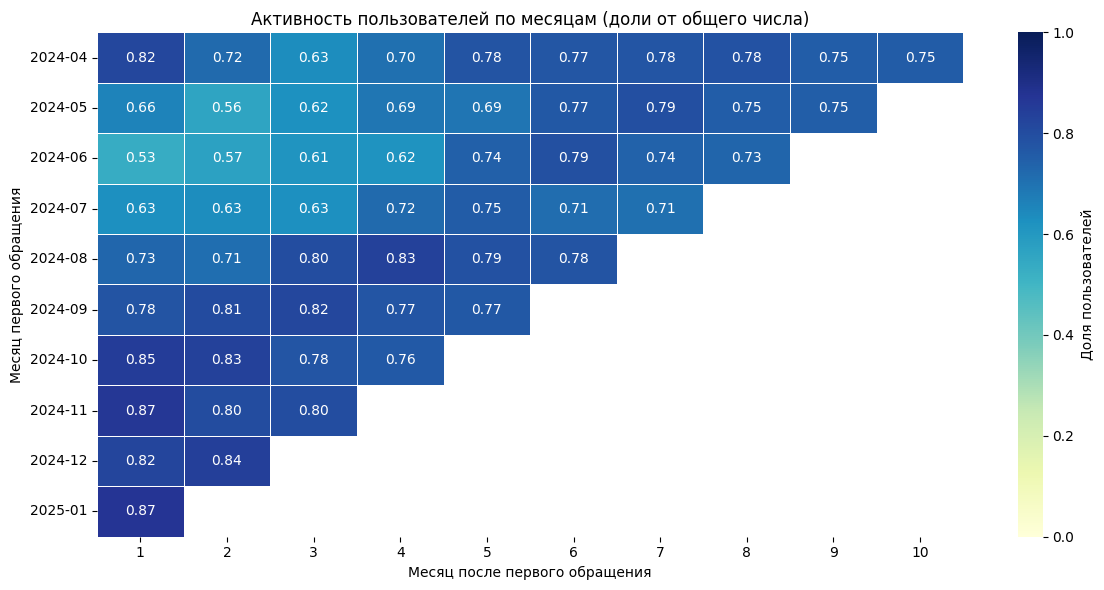

In [24]:
# Построение тепловой карты

result.index = pd.to_datetime(result.index)

result_sorted = result.sort_index(ascending=False)

active_months = [col for col in result.columns if col != 'total_users']
active_months_sorted = sorted(active_months, key=lambda x: int(x))
result_sorted = result_sorted[active_months_sorted]

result_ratios = result_sorted.div(result['total_users'], axis=0)

plt.figure(figsize=(12, 6))

mask = result_ratios == 0

annotations = result_ratios.map(lambda x: f"{x:.2f}" if x != 0 else "")

heatmap = sns.heatmap(result_ratios, annot=annotations,fmt="", cmap="YlGnBu",linewidths=0.5,
                      cbar_kws={"label": "Доля пользователей"}, vmin=0, vmax=1, mask=mask)

y_tick_positions = [i + 0.5 for i in range(len(result_ratios))]
plt.yticks(ticks=y_tick_positions, labels=result_ratios.index.strftime("%Y-%m"), rotation=0)

plt.title("Активность пользователей по месяцам (доли от общего числа)")
plt.xlabel("Месяц после первого обращения")
plt.ylabel("Месяц первого обращения")
plt.tight_layout()

Тепловая карта по неделям

In [25]:
appeals = appeals_init.copy()
navigation = navigation_init.copy()

In [26]:
appeals = appeals.dropna()
appeals = appeals.drop("question_id", axis=1)
appeals["user_id"] = appeals["user_id"].astype("int64")
appeals["created_time"] = pd.to_datetime(appeals["created_time"])
appeals["rate"] = appeals["rate"].map({"Очень плохо": 1, "Плохо": 2, "Нормально": 3, "Хорошо": 4, "Отлично": 5})
appeals["type_closed"] = appeals["type_closed"].map({"Закрыто на Чат-Боте": 0, "Закрыто на агенте": 1})
appeals.head()

,user_id_native,user_id,created_time,rate,ready_recommend,type_closed
3989,1.034575e+09,9311172462,2025-01-05,4,7,1
3990,1.034575e+09,9311172462,2025-03-11,4,10,0
3991,1.034570e+09,9311130045,2024-12-18,4,9,1
3992,1.034570e+09,9311130045,2025-03-11,4,4,0
3993,1.034567e+09,9311099904,2024-12-07,4,5,1


In [27]:
navigation = navigation.dropna()
navigation["dt"] = pd.to_datetime(navigation["dt"])
navigation.head()

,user_id,dt
0,1485848484,2024-07-10
1,1485848484,2024-05-22
2,1485848484,2024-07-24
3,1485848484,2024-05-07
4,1485848484,2024-06-28


In [28]:
# Ищем первый день, по которому полные данные
week_min = max(appeals["created_time"].min(), navigation["dt"].min())

In [29]:
# Ищем первый понедельник, по которому есть полная информация
week_min = week_min + pd.DateOffset(days=(6 - week_min.weekday()) % 7 + 1)  

In [30]:
# Ищем последний день, по которому есть полные данные
week_max = min(appeals["created_time"].max(), navigation["dt"].max())

In [31]:
# Ищем последний понедельник, до которого (не включительно) есть полные данные
week_max = week_max - pd.DateOffset(days=week_max.weekday())

In [32]:
print(f"Между неделей {week_min.strftime('%Y-%m-%d')} (включительно) и неделей {week_max.strftime('%Y-%m-%d')} (не включительно)")

Между неделей 2024-03-04 (включительно) и неделей 2025-03-10 (не включительно)


In [33]:
# Оставляем только полные данные
appeals = appeals[(appeals['created_time'] >= week_min) & (appeals['created_time'] < week_max)]

In [34]:
# Оставляем только полные данные
navigation = navigation[(navigation['dt'] >= week_min) & (navigation['dt'] < week_max)]

In [35]:
# Неделя, в которой было обращение
appeals['week'] = (appeals['created_time'] - week_min).dt.days // 7

In [36]:
# Неделя, в которой было попадание в навигацию
navigation['week'] = (navigation['dt'] - week_min).dt.days // 7

In [37]:
first_appeals = appeals.sort_values(['user_id', 'created_time']).drop_duplicates('user_id')[
    ['user_id', 'week']].rename(columns={'week': 'first_week'})

In [38]:
navigation_filtered = navigation[navigation['user_id'].isin(first_appeals['user_id'])]

In [39]:
merged = pd.merge(navigation_filtered, first_appeals, on='user_id')

In [40]:
merged['week_diff'] = merged['week'] - merged['first_week']

In [41]:
# Нас интересует ситуация после обращения
merged = merged[merged['week_diff'] > 0]

In [42]:
result = merged.groupby(['first_week', 'week_diff'])['user_id'].nunique().unstack().fillna(0).astype(int)

In [43]:
result = result.sort_index()

In [44]:
result['total_users'] = (first_appeals['first_week'].value_counts().sort_index())

In [45]:
def format_dates(d1, d2):
    if d1 > d2:
        d1, d2 = d2, d1
    
    months = ['янв', 'фев', 'март', 'апр', 'май', 'июнь',
              'июль', 'авг', 'сен', 'окт', 'нояб', 'дек']

    day1 = d1.day
    day2 = d2.day
    month1 = months[d1.month - 1]
    month2 = months[d2.month - 1]
    year1 = d1.year
    year2 = d2.year

    if year1 == year2:
        if d1.month == d2.month:
            return f'{day1} - {day2} {month1} {year1}'
        else:
            return f'{day1} {month1} - {day2} {month2} {year1}'
    else:
        return f'{day1} {month1} {year1} - {day2} {month2} {year2}'

In [46]:
formated_dates = result.index.map(lambda x: f"""{format_dates(week_min + pd.DateOffset(weeks=x), 
                                                            week_min + pd.DateOffset(weeks=x + 1) - pd.DateOffset(nanoseconds=1))}""")

In [47]:
result = result.sort_index()
result.head()

week_diff,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,total_users
first_week,,,,,,,,,,,,,,,,,,,,,
0,4288,3925,3698,3756,3793,3743,3624,3440,3471,3544,...,3224,3465,3446,3463,3455,3469,3449,3478,3461,5664
1,7455,6580,6529,6618,6461,6261,5875,5927,6141,5921,...,6275,6199,6282,6296,6279,6224,6306,6296,0,10847
2,4706,4549,4515,4423,4254,3971,4024,4089,4014,3793,...,4046,4070,4052,4051,4030,4020,3998,0,0,6417
3,4630,4381,4268,4110,3829,3863,3945,3838,3717,3350,...,3858,3888,3898,3832,3862,3841,0,0,0,6123
4,5163,4943,4693,4386,4424,4467,4380,4118,3741,3584,...,4336,4321,4310,4343,4288,0,0,0,0,6644


In [51]:
result.to_csv("./heatmaps/weeks.csv")

In [52]:
result = pd.read_csv("./heatmaps/weeks.csv", index_col=0, header=0)

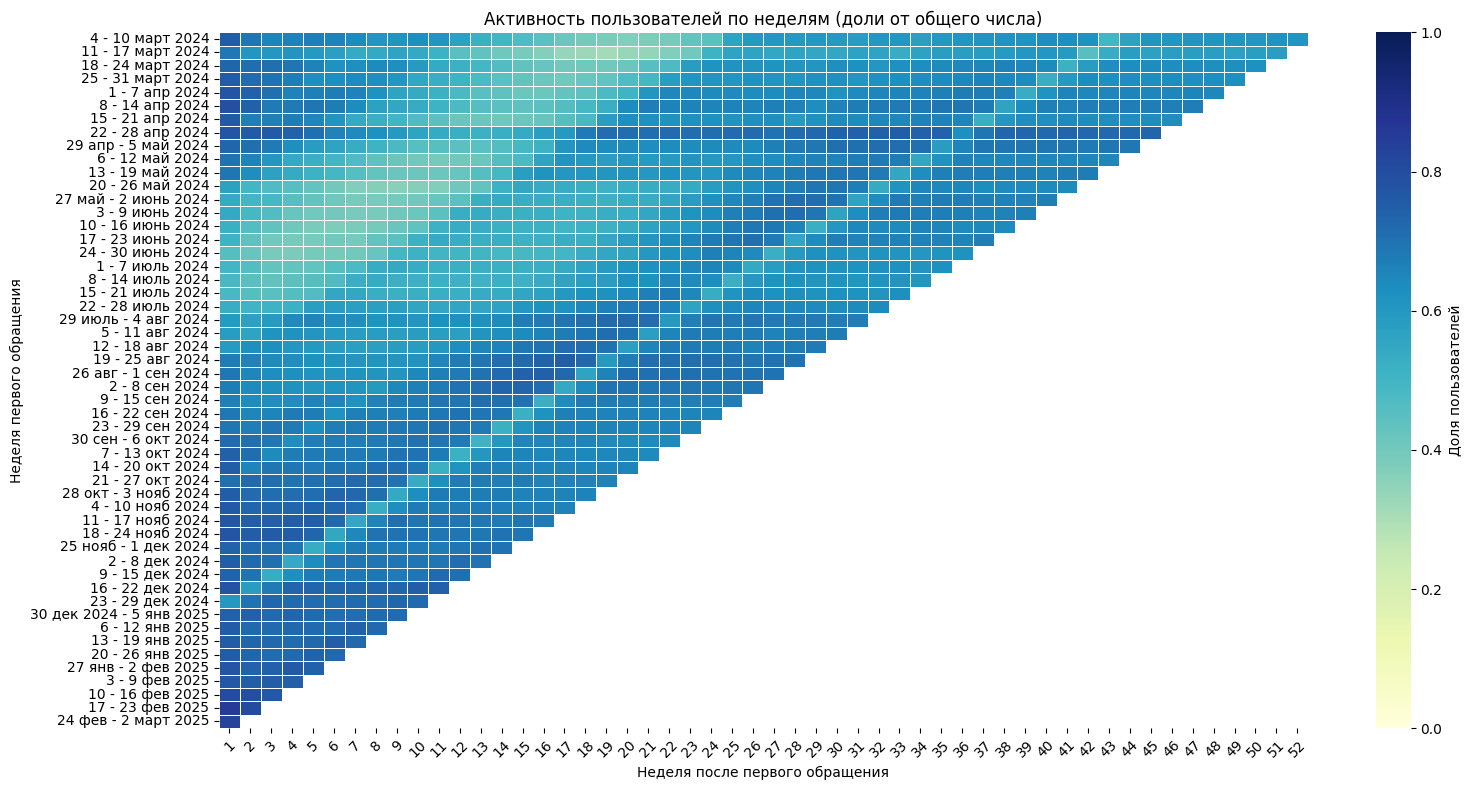

In [53]:
result_sorted = result.sort_index(ascending=False)

active_weeks = [col for col in result.columns if col != 'total_users']
active_weeks_sorted = sorted(active_weeks, key=lambda x: int(x))
result_sorted = result_sorted[active_weeks_sorted]

result_ratios = result_sorted.div(result['total_users'], axis=0)

plt.figure(figsize=(16, 8))

mask = result_ratios == 0

heatmap = sns.heatmap(
    result_ratios,
    fmt="", 
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Доля пользователей"},
    vmin=0,
    vmax=1,
    mask=mask 
)

y_tick_positions = [i + 0.5 for i in range(len(result_ratios))]
plt.xticks(rotation=45)
plt.yticks(
    ticks=y_tick_positions,
    labels=formated_dates,
    rotation=0
)

plt.title("Активность пользователей по неделям (доли от общего числа)")
plt.xlabel("Неделя после первого обращения")
plt.ylabel("Неделя первого обращения")
plt.tight_layout()